In [ ]:
# Mouting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import datetime
import gc
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import *
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from tensorflow.math import confusion_matrix

%load_ext tensorboard

In [ ]:
batchSize = 32
imageHeight = 200
imageWidth = 200
randomisingSeed = 108
colorMode = "grayscale"
validationSplitFraction = 0.2
imageInterpolationMethod  = "bilinear"
cropToPreserveAspectRatioWhileResizing = False

augmentDataset = False
cropBottomPanel = False

earlyStoppingMetric = "val_accuracy"
earlyStoppingMinimumImprovementCriterion = 0.005
earlyStoppingPatience = 6

baselineAccuracy = 0.1

learningRateReductionMetric = 'val_loss'
patienceForLearningRateReduction = 4
learningRateReductionFactor = 0.1
learningRateReductionMinimumImprovementCriterion = 0.001
learningRateReductionCooldown = 15
minimumLearningRate = 0

useTensorboard = True

In [ ]:
# Daatset locations on G drive
# Make sure that the daatset folder is there in drive
# And that a seeprate tmpModelBackup folder has been created for each model that runs at a given time
datasetName = 'SEM100'
modelName = 'basicOptimsation_grayscale_notCropped_notAugemnted_learningRateReduction10x_seed108_imageSize200_restDefault'
trainingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/train'
testingDataPath = '/content/drive/MyDrive/SEMProject/' + datasetName + '/test'
historySaveLocation = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/history/' + modelName + 'data.pickle'
modelSaveLocation = '/content/drive/MyDrive/SEMProject/SEM100/models/finalModels/' + modelName + '.h5'

rootLogsDirectory = '/content/drive/MyDrive/SEMProject/' + datasetName + "/logs/"
log_dir = rootLogsDirectory + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
def getDataset(batchSize, imageHeight, imageWidth, randomisingSeed, colorMode, validationSplitFraction, imageInterpolationMethod, cropToPreserveAspectRatioWhileResizing, augmentDataset, cropBottomPanel):
  trainingDataset, validationDataset = tf.keras.utils.image_dataset_from_directory(
      directory = trainingDataPath,
      labels = "inferred",
      label_mode = "categorical",
      color_mode = colorMode,
      batch_size = batchSize,
      image_size = (imageHeight, imageWidth),
      seed = randomisingSeed,
      shuffle = True,
      validation_split = validationSplitFraction,
      subset="both",
      interpolation = imageInterpolationMethod,
      crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
      )

  testingDataset = tf.keras.utils.image_dataset_from_directory(
    directory = testingDataPath,
    labels = 'inferred',
    label_mode = "categorical",
    color_mode = colorMode,
    batch_size = batchSize,
    image_size = (imageHeight, imageWidth),
    seed=  randomisingSeed,
    shuffle = True,
    interpolation = imageInterpolationMethod,
    crop_to_aspect_ratio = cropToPreserveAspectRatioWhileResizing
    )

  classNames = np.array(trainingDataset.class_names)
  print(classNames)

  def cropBottomPanel(image, label):
    return tf.image.crop_to_bounding_box(image, offset_height = 0, offset_width = 0, target_height = int(imageHeight * 600/ 768), target_width = imageWidth), label

  if cropBottomPanel:
    trainingDataset = trainingDataset.map(cropBottomPanel)
    validationDataset = validationDataset.map(cropBottomPanel)
    testingDataset = testingDataset.map(cropBottomPanel)
    imageHeight = int(imageHeight * 600/ 768)

  augmentedTrainingDataset = trainingDataset

  if augmentDataset:
    dataAugmentation = keras.Sequential(
        [
            layers.RandomRotation(factor = (-0.5, 0.5), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomFlip(mode = "horizontal_and_vertical", seed = randomisingSeed),
            layers.RandomTranslation(height_factor = (-0.2, 0.2), width_factor = (-0.2, 0.2), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomZoom(height_factor = (-0.3, 0.3), width_factor = (-0.2, 0.2), fill_mode = "nearest", interpolation = imageInterpolationMethod, seed = randomisingSeed),
            layers.RandomContrast(factor = (0.4, 0.3), seed = randomisingSeed)
        ]
    )

    augmentedTrainingDataset = trainingDataset.map(lambda x, y: (dataAugmentation(x), y))

  AUTOTUNE = tf.data.AUTOTUNE

  if augmentDataset:
    augmentedTrainingDataset = augmentedTrainingDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  else:
    trainingDataset = trainingDataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

  validationDataset = validationDataset.cache().prefetch(buffer_size=AUTOTUNE)

  return trainingDataset, augmentedTrainingDataset, validationDataset, testingDataset, classNames, imageHeight

In [ ]:
def visualiseDataset(dataset, noOfRows, noOfColumns):
  plt.figure(figsize=(noOfRows*2.5, noOfColumns*2.5))

  for images, labels in dataset.take(1):
    for i in range(noOfRows * noOfColumns):
      ax = plt.subplot(noOfRows, noOfColumns, i + 1)

      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(classNames[ np.argmax(labels[i]) ])

      plt.axis("off")

In [ ]:
def learningRateSchedule(currentEpochNumber, learningRatefromPreviousEpoch):
    learningRateForCurrentEpoch = learningRatefromPreviousEpoch
    return learningRateForCurrentEpoch

In [ ]:
def getCallbacks(datasetName, modelName, earlyStoppingMetric, earlyStoppingMinimumImprovementCriterion, earlyStoppingPatience,
                 baselineAccuracy,
                 learningRateReductionMetric, learningRateReductionFactor, patienceForLearningRateReduction,
                 learningRateReductionMinimumImprovementCriterion, learningRateReductionCooldown):
  callbackList = []

  callbackList.append(BackupAndRestore(backup_dir = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/tmpModelBackup/' + modelName + 'epoch_{epoch:04d}.h5', save_freq = 'epoch',
                                    delete_checkpoint = True, save_before_preemption = False))

  callbackList.append(EarlyStopping(monitor = earlyStoppingMetric, min_delta = earlyStoppingMinimumImprovementCriterion, patience = earlyStoppingPatience,
                                    verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True, start_from_epoch = 0))

  #def learningrateSchedule(currentEpochNumber, learningRatefromPreviousEpoch):
  #  learningRateForCurrentEpoch = learningRatefromPreviousEpoch
  #  return learningRateForCurrentEpoch

  #callbackList.append(LearningRateScheduler(learningRateSchedule(epoch, lr), verbose = 1))

  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/allTrainingModels/' + modelName + 'epoch_{epoch:04d}.h5',
                                      monitor = 'val_loss', verbose = 1, save_best_only = False, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = None))
  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/finalModels/' + modelName + 'MostAccurateEpoch_{epoch:04d}.h5',
                                      monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = baselineAccuracy))
  callbackList.append(ModelCheckpoint(filepath = '/content/drive/My Drive/SEMProject/' + datasetName + '/models/finalModels/' + modelName + 'LeastLossEpoch_{epoch:04d}.h5',
                                      monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch',
                                      options = None, initial_value_threshold = None))

  callbackList.append(ReduceLROnPlateau(monitor = learningRateReductionMetric, factor = learningRateReductionFactor, patience = patienceForLearningRateReduction,
                                        verbose = 1, mode='auto', min_delta = learningRateReductionMinimumImprovementCriterion, cooldown = learningRateReductionCooldown,
                                        min_lr = minimumLearningRate))

  callbackList.append(TerminateOnNaN())

  if useTensorboard:
    callbackList.append(tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1))

  return callbackList

In [ ]:
maxPoolingSize = (2, 2)
maxPollingPadding = 'valid'

convolutionKernelSize = 3
convolutionKernelRegulariser = None
convolutionActivityRegulariser = None

In [ ]:
def getBaselineModel(classNames, convolutionKernelRegulariser, convolutionActivityRegulariser):
  numberOfClasses = len(classNames)

  model = Sequential([
    layers.Rescaling(1./255, input_shape=(imageHeight, imageWidth, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.Dropout(0.1),
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer = convolutionKernelRegulariser, activity_regularizer = convolutionActivityRegulariser),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(128, activation='relu'),
    layers.Dense(numberOfClasses)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy',  'categorical_crossentropy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  model.summary()

  return model

In [ ]:
def saveHistoryAndFinalModel(model, history):
  with open(historySaveLocation, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

  model.save(modelSaveLocation)

In [ ]:
trainingDataset, augmentedTrainingDataset, validationDataset, testingDataset, classNames, imageHeight = getDataset(batchSize = batchSize,
                                                                                                      imageHeight = imageHeight, imageWidth = imageWidth,
                                                                                                      randomisingSeed = randomisingSeed,
                                                                                                      colorMode = colorMode,
                                                                                                      validationSplitFraction = validationSplitFraction,
                                                                                                      imageInterpolationMethod = imageInterpolationMethod,
                                                                                                      cropToPreserveAspectRatioWhileResizing = cropToPreserveAspectRatioWhileResizing,
                                                                                                      augmentDataset = augmentDataset, cropBottomPanel = cropBottomPanel)

Found 1223 files belonging to 10 classes.
Using 979 files for training.
Using 244 files for validation.
Found 319 files belonging to 10 classes.
['Biological' 'Fibres' 'Films_Coated_Surface'
 'MEMS_devices_and_electrodes' 'Nanowires' 'Particles' 'Patterned_surface'
 'Porous_Sponge' 'Powder' 'Tips']


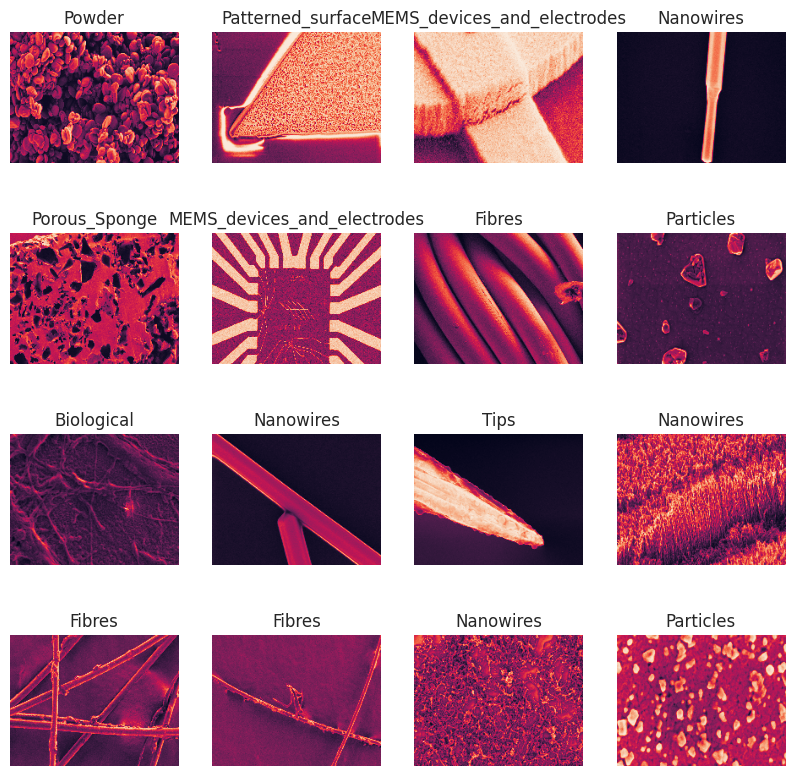

In [ ]:
visualiseDataset(augmentedTrainingDataset, 4, 4)

In [ ]:
callbacks = getCallbacks(datasetName = datasetName, modelName = modelName,
                         earlyStoppingMetric = earlyStoppingMetric, earlyStoppingMinimumImprovementCriterion = earlyStoppingMinimumImprovementCriterion,
                         earlyStoppingPatience = earlyStoppingPatience,
                         baselineAccuracy = baselineAccuracy,
                         learningRateReductionMetric = learningRateReductionMetric, learningRateReductionFactor = learningRateReductionFactor,
                         patienceForLearningRateReduction = patienceForLearningRateReduction,
                         learningRateReductionMinimumImprovementCriterion = learningRateReductionMinimumImprovementCriterion,
                         learningRateReductionCooldown = learningRateReductionCooldown)

model = getBaselineModel(classNames, convolutionKernelRegulariser,  convolutionActivityRegulariser)

history = model.fit(
  augmentedTrainingDataset,
  validation_data=validationDataset,
  epochs = 1000,
  verbose=1,
  callbacks = callbacks
)

saveHistoryAndFinalModel(model, history)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 156, 200, 1)       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 156, 200, 16)      160       
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 78, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 78, 100, 32)       4640      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 39, 50, 32)       0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 39, 50, 32)       

In [ ]:
with open(historySaveLocation, "rb") as file_pi:
    history = pickle.load(file_pi)

In [ ]:
model = tf.keras.models.load_model(modelSaveLocation)

In [ ]:
def plotHistory(history):
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history['categorical_crossentropy'])
  plt.plot(history['val_categorical_crossentropy'])
  plt.title('model cross entropy')
  plt.ylabel('cross entropy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history['precision_1'])
  plt.plot(history['val_precision_1'])
  plt.title('model precision')
  plt.ylabel('precision')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history['recall'])
  plt.plot(history['val_recall'])
  plt.title('model recall')
  plt.ylabel('recall')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history['lr'])
  plt.title('model learning rate')
  plt.ylabel('learning rate')
  plt.xlabel('epoch')
  plt.legend(['learning rate'], loc='upper left')
  plt.show()

In [ ]:
def PerformanceReports(confusionMatrix,classificationReport,labels):
    ax= plt.subplot()
    sns.heatmap(confusionMatrix, annot=True,ax=ax)
    #labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
    ax= plt.subplot()
    sns.heatmap(pd.DataFrame(classificationReport).iloc[:-1, :].T,
                annot=True,ax=ax)
    ax.set_title('Classification Report')
    plt.show()

In [ ]:
def evaluateModelOnDataset(model, dataset):
  predictedClasses = np.array([])
  trueLabels = np.array([])

  for x, y in dataset:
      predictedClasses = np.concatenate([predictedClasses, np.argmax(model(x), axis=-1)])
      trueLabels = np.concatenate([trueLabels, np.argmax(y.numpy(), axis=-1)])

  confusionMatrix = confusion_matrix(labels= trueLabels, predictions=predictedClasses).numpy()
  classificationReport=classification_report(trueLabels, predictedClasses,
                                      target_names=classNames,
                                      output_dict=True)
  PerformanceReports(confusionMatrix, classificationReport, classNames)

In [ ]:
def evaluatedModel(model):
  scoresTraining = model.evaluate(trainingDataset,verbose=1)
  scoresValidation = model.evaluate(validationDataset,verbose=1)
  scoresTesting = model.evaluate(testingDataset,verbose=1)
  print("Train Accuracy: %.2f%%" % (scoresTraining[1]*100))
  print("Validation Accuracy: %.2f%%" % (scoresValidation[1]*100))
  print("testing Accuracy: %.2f%%" % (scoresTesting[1]*100))

  print(history.keys())
  plotHistory(history)

  evaluateModelOnDataset(model, trainingDataset)
  evaluateModelOnDataset(model, validationDataset)
  evaluateModelOnDataset(model, testingDataset)

10/10 [==============================] - 2s 33ms/step - loss: 2.2593 - accuracy: 0.1850 - categorical_crossentropy: 7.6296 - precision_1: 0.0000e+00 - recall: 0.0000e+00
Train Accuracy: 16.14%
Validation Accuracy: 12.70%
testing Accuracy: 18.50%
dict_keys(['loss', 'accuracy', 'categorical_crossentropy', 'precision_1', 'recall', 'val_loss', 'val_accuracy', 'val_categorical_crossentropy', 'val_precision_1', 'val_recall', 'lr'])


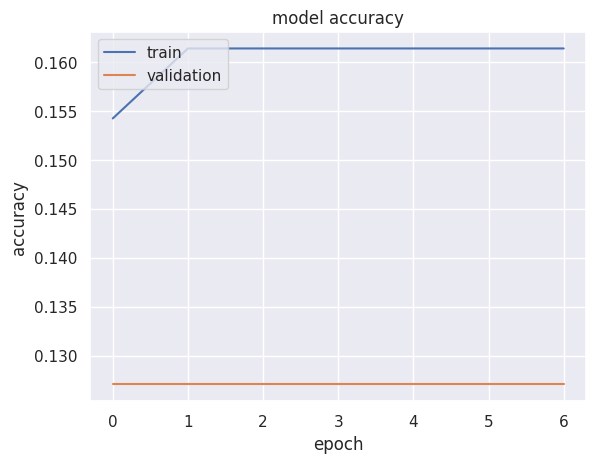

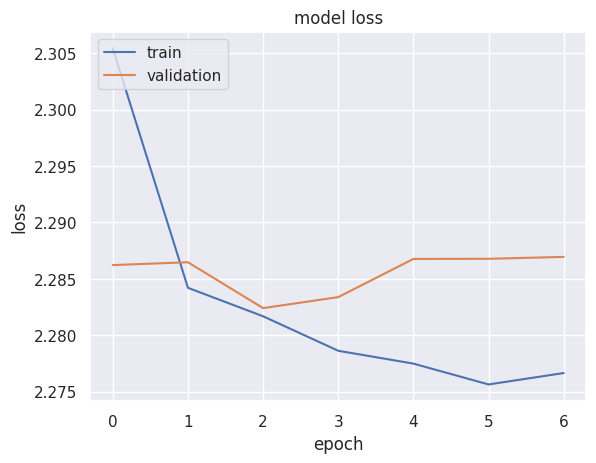

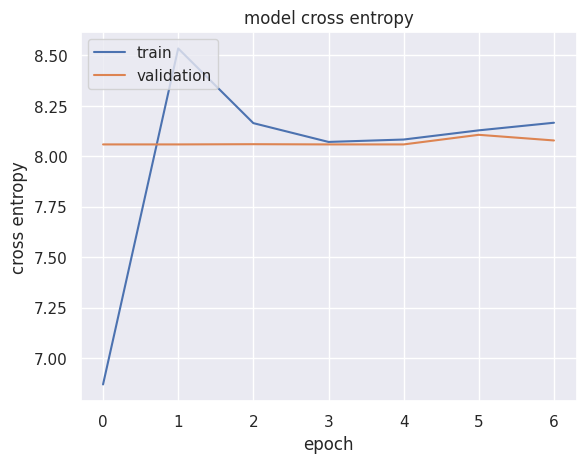

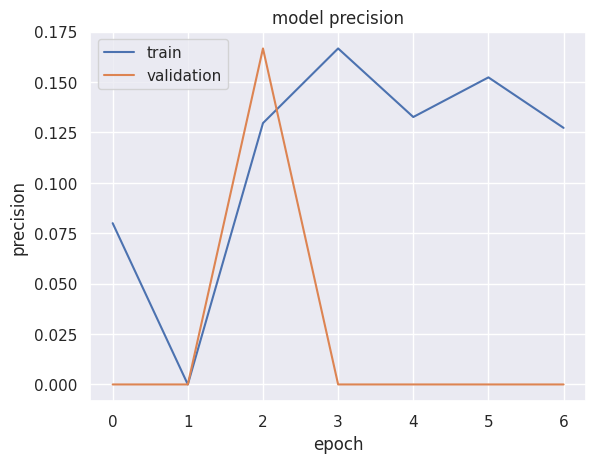

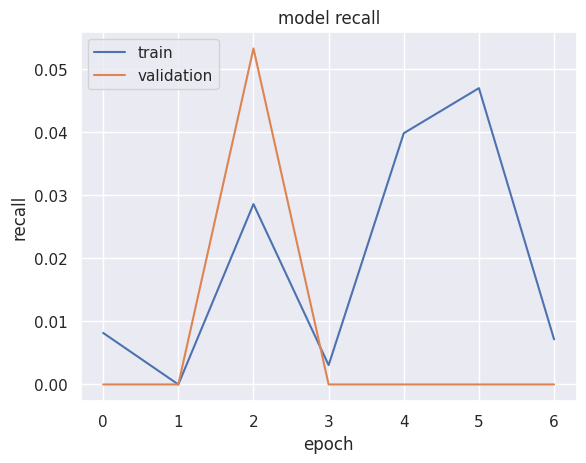

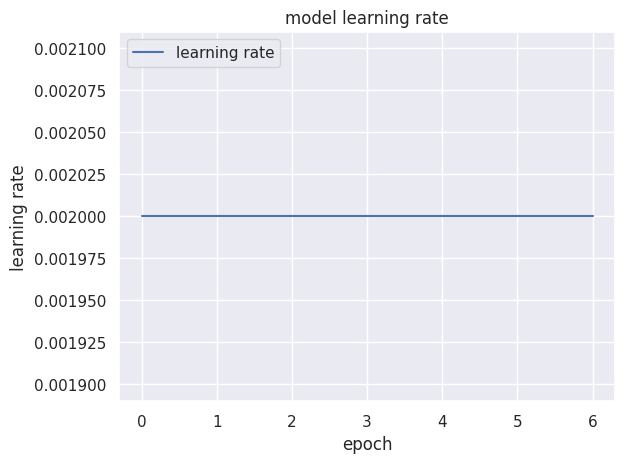

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


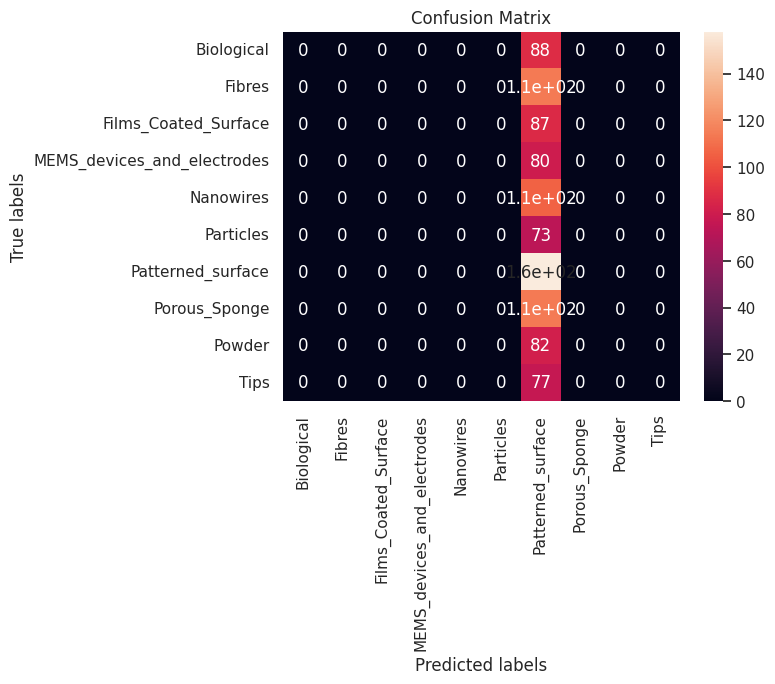

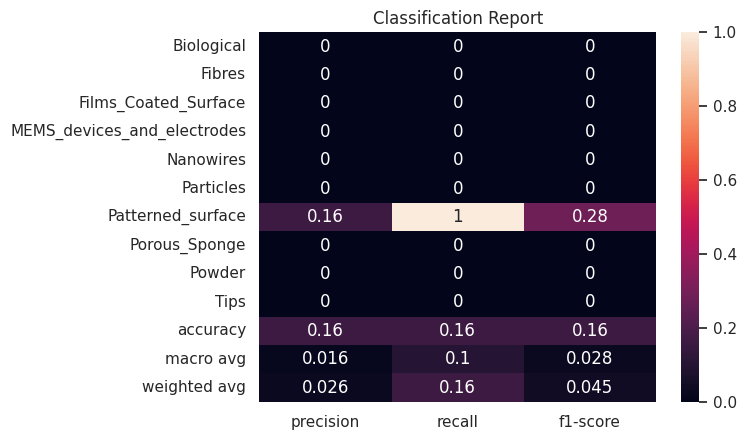

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


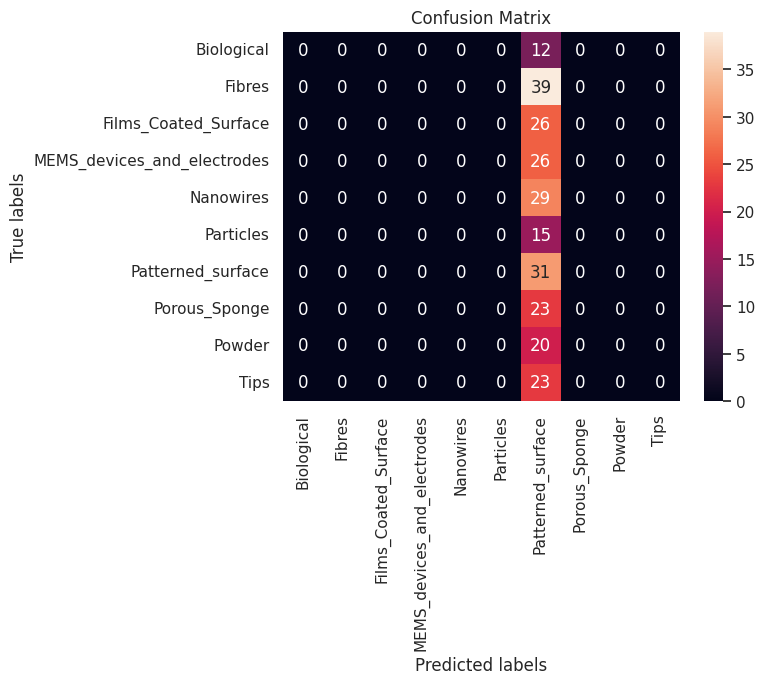

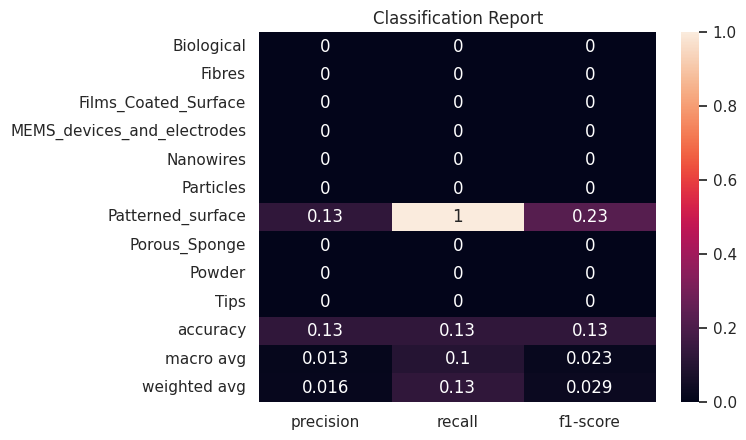

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


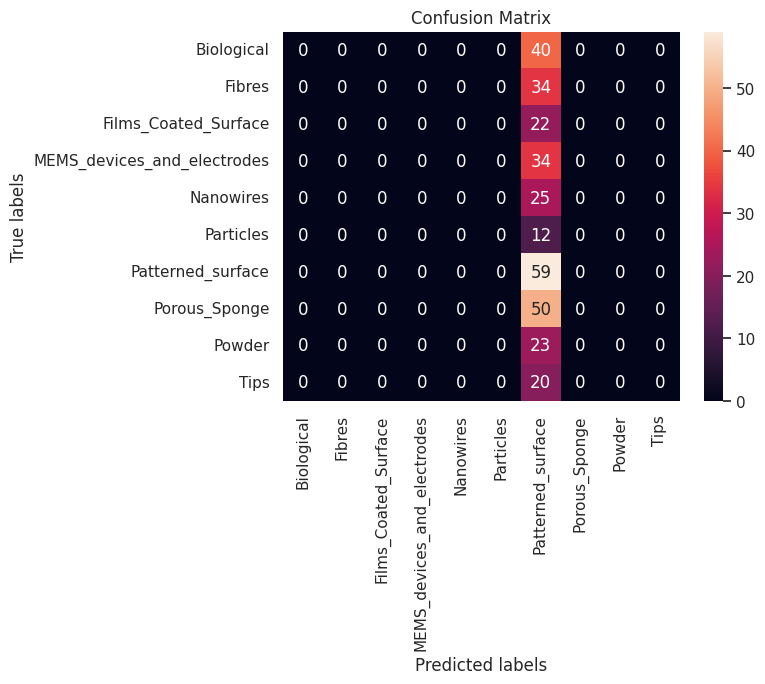

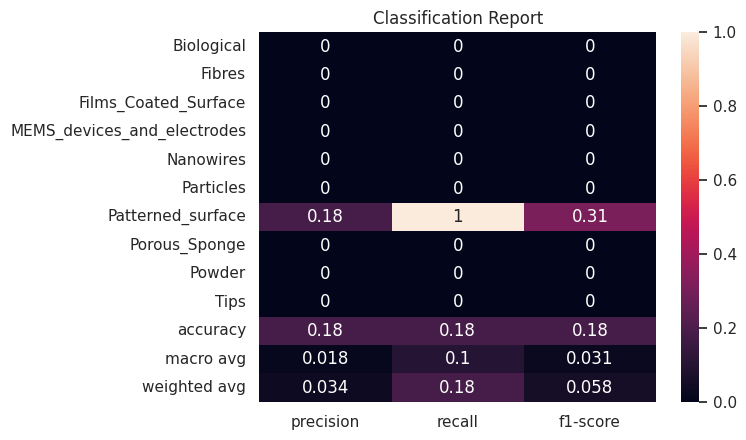

In [ ]:
evaluatedModel(model)

In [ ]:
print(history)

{'loss': [2.305436134338379, 2.284205913543701, 2.2816808223724365, 2.278620958328247, 2.277482509613037, 2.275634288787842, 2.276646375656128], 'accuracy': [0.1542390137910843, 0.16138917207717896, 0.16138917207717896, 0.16138917207717896, 0.16138917207717896, 0.16138917207717896, 0.16138917207717896], 'categorical_crossentropy': [6.870166301727295, 8.534402847290039, 8.1644868850708, 8.0714111328125, 8.083257675170898, 8.128782272338867, 8.166465759277344], 'precision_1': [0.07999999821186066, 0.0, 0.12962962687015533, 0.1666666716337204, 0.13265305757522583, 0.15231788158416748, 0.12727272510528564], 'recall': [0.00817160401493311, 0.0, 0.02860061265528202, 0.003064351389184594, 0.039836566895246506, 0.04698672145605087, 0.007150153163820505], 'val_loss': [2.286221504211426, 2.286473274230957, 2.282404899597168, 2.283379554748535, 2.2867679595947266, 2.2867791652679443, 2.286947727203369], 'val_accuracy': [0.12704917788505554, 0.12704917788505554, 0.12704917788505554, 0.127049177885